In [23]:
import sys
sys.path.append('../') 

In [56]:

%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params:

In [57]:
aggregate_by_state = False
outcome_type = 'deaths'

## Basic Data Visualization

In [58]:
# Just something to quickly summarize the number of cases and distributions each day

In [59]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
df = df.sort_values('#Deaths_3/28/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
                       'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

In [60]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
1846


(array([70., 56., 26., 26., 21., 14., 13.,  9., 12., 11.,  8.,  7., 10.,
         5.,  4.,  4.,  3.,  1.,  7.,  4.,  3.,  2.,  4.,  3.,  3.,  1.,
         2.,  3.,  3.,  1.,  1.,  0.,  2.,  2.,  0.,  0.,  1.,  0.,  1.,
         1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
         3.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 21.  ,  29.91,  38.82,  47.73,  56.64,  65.55,  74.46,  83.37,
         92.28, 101.19, 110.1 , 119.01, 127.92, 136.83, 145.74, 154.65,
        163.56, 172.47, 181.38, 190.29, 199.2 , 208.11, 217.02, 225.93,
        234.84, 243.75, 252.66, 261.57, 270.48, 279.39, 288.3 , 297.21,
        306.12, 315.03, 323.94, 332.85, 341.76, 350.67, 359.58, 368.49,
        377.4 , 386.31, 395.22, 404.13, 413.04, 421.95, 430.86, 439.77,
  

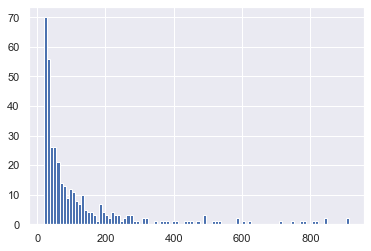

In [61]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [62]:
sum(max_cases)

118752

In [63]:
print(sum([v > 50 for v in max_cases]))


228


In [64]:
np.quantile(max_cases,.5)

1.0

Number of counties with non-zero deaths
365


(array([30.,  6.,  4.,  4.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  6.,  13.,  20.,  27.,  34.,  41.,  48.,  55.,  62.,  69.,  76.,
         83.,  90.,  97., 104., 111., 118., 125., 132., 139., 146., 153.,
        160., 167., 174., 181., 188., 195., 202., 209., 216.]),
 <a list of 30 Patch objects>)

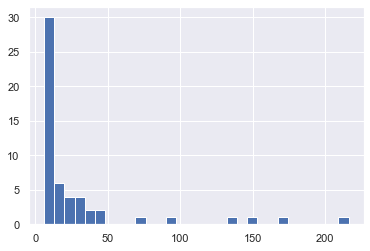

In [65]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

print('Number of counties with non-zero deaths')
print(sum([v >0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 5],bins=30)

In [66]:
sum(max_deaths)

2075

In [67]:
max(max_deaths)

216

In [68]:
np.quantile(max_deaths,.7)

0.0

### Clean data

In [69]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
max_deaths = [max(v) for v in df['deaths']]
df['max_deaths'] = max_deaths
df =  df[df['max_cases'] > 0]



## Predict data from model:

In [70]:
# Trains model on train_df and produces predictions for the final day for test_df and writes prediction
# to a new column for test_df 
fit_and_predict(df, method='exponential', outcome=outcome_type, mode='eval_mode',target_day=[1])
fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',target_day=[1])
# fit_and_predict(train_df, test_df,'shared_exponential', mode='eval_mode',demographic_vars=important_vars)
fit_and_predict( df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',demographic_vars=very_important_vars,target_day=[1])
fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=very_important_vars,
                                    method='ensemble',target_day=[1])
# fit_and_predict(train_df, test_d f,method='exponential',mode='eval_mode',target_day = np.array([1,2]))

# Finds the names of all the methods
method_keys = [c for c in df if 'predicted' in c]
method_keys

Feature weights
log(deaths) : 0.9629253635498851
bias : 0.3036498058330107
Feature weights
PopulationDensityperSqMile2010 : 8.760898643264837e-06
MedicareEnrollment,AgedTot2017 : -2.135261454236374e-06
PopulationEstimate2018 : 2.991334712053297e-07
#ICU_beds : -0.00035255654413933284
MedianAge2010 : 0.05209244038585084
Smokers_Percentage : -0.008691217889699494
DiabetesPercentage : 0.045000060777174326
HeartDiseaseMortality : 0.0012512101345352696
#Hospitals : 0.009556310944111602
log(deaths) : 0.903226389933989
bias : -2.0095115565978885
Feature weights
PopulationDensityperSqMile2010 : 8.760898643264837e-06
MedicareEnrollment,AgedTot2017 : -2.135261454236374e-06
PopulationEstimate2018 : 2.991334712053297e-07
#ICU_beds : -0.00035255654413933284
MedianAge2010 : 0.05209244038585084
Smokers_Percentage : -0.008691217889699494
DiabetesPercentage : 0.045000060777174326
HeartDiseaseMortality : 0.0012512101345352696
#Hospitals : 0.009556310944111602
log(deaths) : 0.903226389933989
bias : -2.00

['predicted_deaths_exponential_1',
 'predicted_deaths_shared_exponential_1',
 'predicted_deaths_shared_exponential_1_demographics',
 'predicted_deaths_ensemble_1']

## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [71]:
# TODO: add average rank as metric

In [72]:
# Computes the mse in log space and non-log space for all columns

In [73]:
def l1(arr1,arr2):
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
lower_threshold, upper_threshold = 10, 1000

In [74]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][(outcome > lower_threshold) * (outcome < upper_threshold)]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[(outcome > lower_threshold) * (outcome < upper_threshold)] + 1),preds))

Log scale MSE for predicted_deaths_exponential_1
0.026669098844956624
Log scale MSE for predicted_deaths_shared_exponential_1
0.018574973438623035
Log scale MSE for predicted_deaths_shared_exponential_1_demographics
0.015392029965072726
Log scale MSE for predicted_deaths_ensemble_1
0.012384430320887013


In [75]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][outcome > lower_threshold]]
    print('Log scale l1 for '+key)
    print(l1(np.log(outcome[outcome > lower_threshold] + 1),preds))

Log scale l1 for predicted_deaths_exponential_1
0.11795418750483481
Log scale l1 for predicted_deaths_shared_exponential_1
0.09775921675155413
Log scale l1 for predicted_deaths_shared_exponential_1_demographics
0.10596008526898563
Log scale l1 for predicted_deaths_ensemble_1
0.08939785890587888


In [76]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > lower_threshold],preds))

Raw MSE for predicted_deaths_exponential_1
38.99878211628958
Raw MSE for predicted_deaths_shared_exponential_1
244.7392729566677
Raw MSE for predicted_deaths_shared_exponential_1_demographics
98.26064489025362
Raw MSE for predicted_deaths_ensemble_1
25.100776011211515


In [77]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds))

Raw l1 for predicted_deaths_exponential_1
4.482177651777733
Raw l1 for predicted_deaths_shared_exponential_1
7.316085229859523
Raw l1 for predicted_deaths_shared_exponential_1_demographics
6.08261326707046
Raw l1 for predicted_deaths_ensemble_1
3.7583378436681185


### Plot residuals

In [78]:
# TODO: Create bounds automatically, create a plot function and call it instead of copying code, figure out way
# to plot more than two things at once cleanly

# Creates residual plots log scaled and raw
# We only look at cases with number of deaths greater than 5

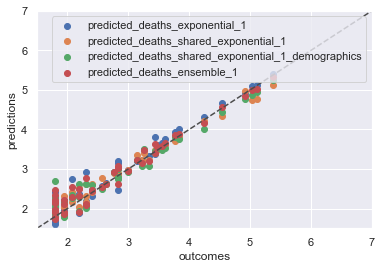

In [79]:
# Make log plots:
bounds = [1.5, 7]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)
    
plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

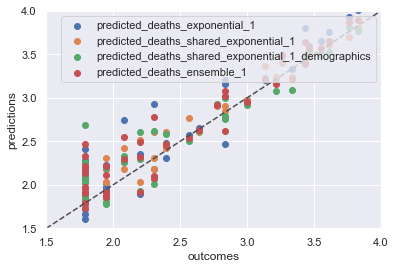

In [80]:
# Make log plots zoomed in for the counties that have a fewer number of deaths
bounds = [1.5, 4]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)

plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

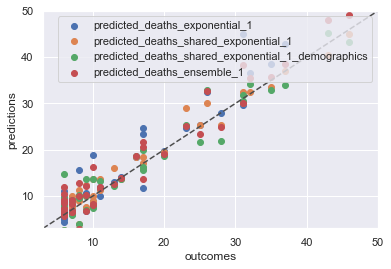

In [81]:
# Make non-log plots zoomed in for the counties that have a fewer number of deaths# We set bounds 
bounds = [3, 50]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=key)

plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

### Graph Visualizations

In [82]:
# Here we visualize predictions on a per county level.
# The blue lines are the true number of deaths, and the dots are our predictions for each model for those days.

In [112]:
'3'.isnumeric()

True

In [116]:
def method_name_to_pretty_name(key):
    # TODO: hacky, fix
    words = key.split('_')
    words2 = []
    for w in words:
        if not w.isnumeric():
            words2.append(w)
            
    model_name = words2[2:]
    return ' '.join(model_name)

In [117]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = 'deaths'
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    sns.lineplot(list(range(len(row[gold_key][start_point:]))),row[gold_key][start_point:], label=gold_key)
    
    

    for key in method_keys:
        preds = row[key]

        sns.scatterplot(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=method_name_to_pretty_name(key))
        
#         plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
#     plt.legend()
#     plt.show()
#     sns.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

    

Queens in NY


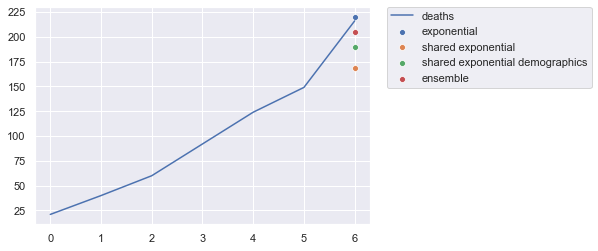

PopulationDensityperSqMile2010: 20553.6
MedicareEnrollment,AgedTot2017: 308099.0
PopulationEstimate2018: 2278906.0
#ICU_beds: 129
MedianAge2010: 37.2
Smokers_Percentage: 12.42777748
DiabetesPercentage: 10.2
HeartDiseaseMortality: 180.0
#Hospitals: 6


Kings in NY


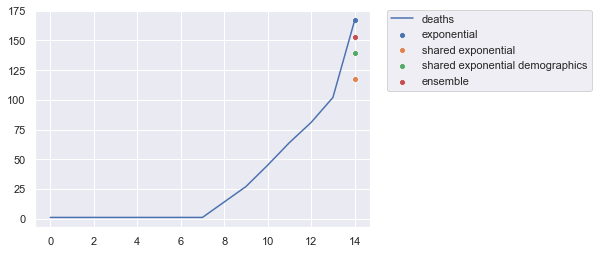

PopulationDensityperSqMile2010: 35369.2
MedicareEnrollment,AgedTot2017: 309657.0
PopulationEstimate2018: 2582830.0
#ICU_beds: 318
MedianAge2010: 34.1
Smokers_Percentage: 13.840801998
DiabetesPercentage: 9.7
HeartDiseaseMortality: 195.8
#Hospitals: 12


Bronx in NY


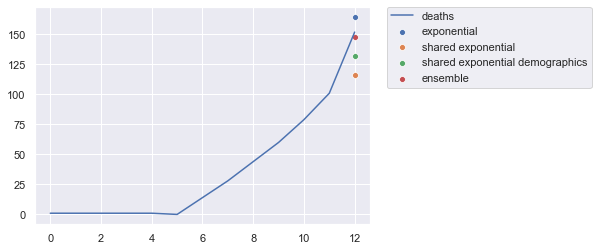

PopulationDensityperSqMile2010: 32903.3
MedicareEnrollment,AgedTot2017: 159057.0
PopulationEstimate2018: 1432132.0
#ICU_beds: 270
MedianAge2010: 32.8
Smokers_Percentage: 15.921168722
DiabetesPercentage: 12.3
HeartDiseaseMortality: 201.3
#Hospitals: 6


King in WA


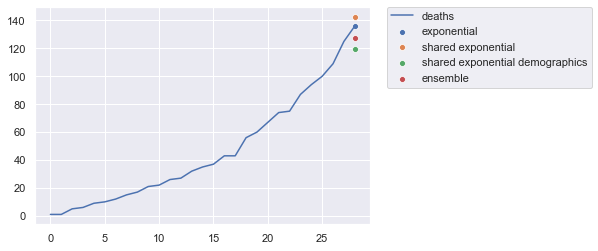

PopulationDensityperSqMile2010: 912.9
MedicareEnrollment,AgedTot2017: 271948.0
PopulationEstimate2018: 2233163.0
#ICU_beds: 450
MedianAge2010: 37.1
Smokers_Percentage: 8.8150454593
DiabetesPercentage: 7.1
HeartDiseaseMortality: 118.9
#Hospitals: 17


New York in NY


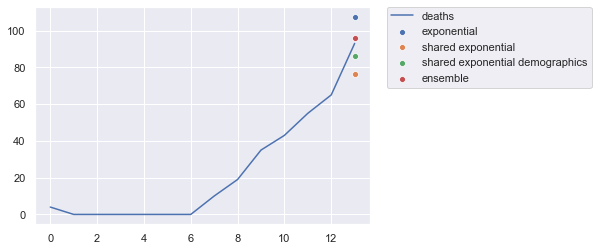

PopulationDensityperSqMile2010: 69468.4
MedicareEnrollment,AgedTot2017: 245044.0
PopulationEstimate2018: 1628701.0
#ICU_beds: 761
MedianAge2010: 36.4
Smokers_Percentage: 12.41823421
DiabetesPercentage: 6.5
HeartDiseaseMortality: 143.5
#Hospitals: 12


Orleans in LA


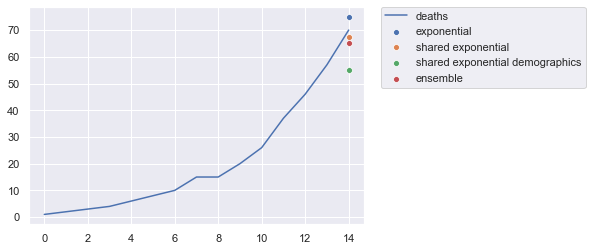

PopulationDensityperSqMile2010: 2029.4
MedicareEnrollment,AgedTot2017: 47122.0
PopulationEstimate2018: 391006.0
#ICU_beds: 111
MedianAge2010: 34.6
Smokers_Percentage: 22.609624129
DiabetesPercentage: 10.3
HeartDiseaseMortality: 189.7
#Hospitals: 5


Wayne in MI


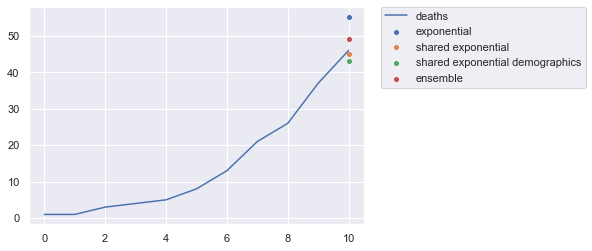

PopulationDensityperSqMile2010: 2974.4
MedicareEnrollment,AgedTot2017: 250815.0
PopulationEstimate2018: 1753893.0
#ICU_beds: 586
MedianAge2010: 37.3
Smokers_Percentage: 21.055529729
DiabetesPercentage: 10.3
HeartDiseaseMortality: 259.2
#Hospitals: 14


Richmond in NY


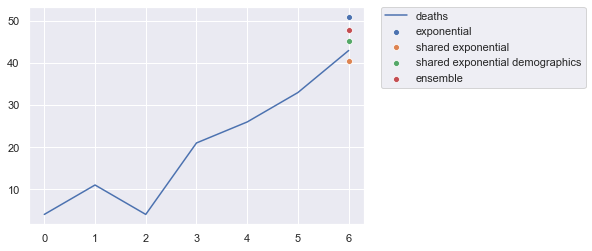

PopulationDensityperSqMile2010: 8030.3
MedicareEnrollment,AgedTot2017: 71228.0
PopulationEstimate2018: 476179.0
#ICU_beds: 114
MedianAge2010: 38.4
Smokers_Percentage: 15.373417772
DiabetesPercentage: 9.6
HeartDiseaseMortality: 239.6
#Hospitals: 2


Suffolk in NY


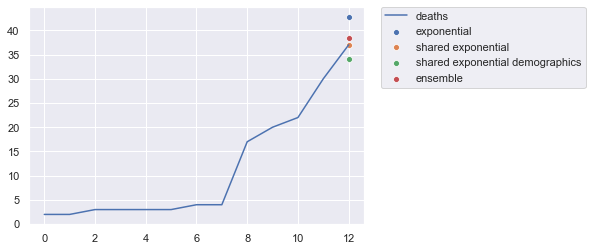

PopulationDensityperSqMile2010: 1637.4
MedicareEnrollment,AgedTot2017: 241037.0
PopulationEstimate2018: 1481093.0
#ICU_beds: 281
MedianAge2010: 39.8
Smokers_Percentage: 12.625481467
DiabetesPercentage: 6.8
HeartDiseaseMortality: 181.8
#Hospitals: 10


Nassau in NY


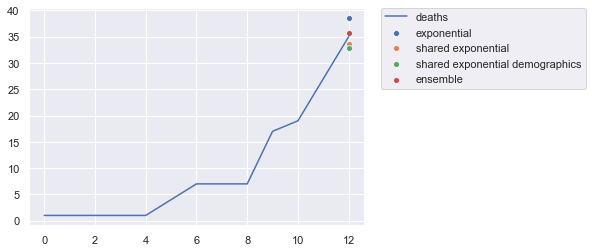

PopulationDensityperSqMile2010: 4704.8
MedicareEnrollment,AgedTot2017: 230244.0
PopulationEstimate2018: 1358343.0
#ICU_beds: 461
MedianAge2010: 41.1
Smokers_Percentage: 11.225364644
DiabetesPercentage: 7.2
HeartDiseaseMortality: 188.2
#Hospitals: 10


Los Angeles in CA


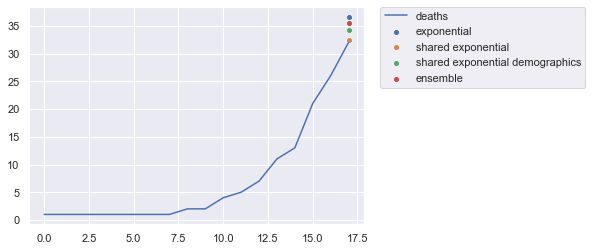

PopulationDensityperSqMile2010: 2419.6
MedicareEnrollment,AgedTot2017: 1276832.0
PopulationEstimate2018: 10105518.0
#ICU_beds: 2126
MedianAge2010: 34.8
Smokers_Percentage: 10.847678109
DiabetesPercentage: 8.1
HeartDiseaseMortality: 150.8
#Hospitals: 76


Oakland in MI


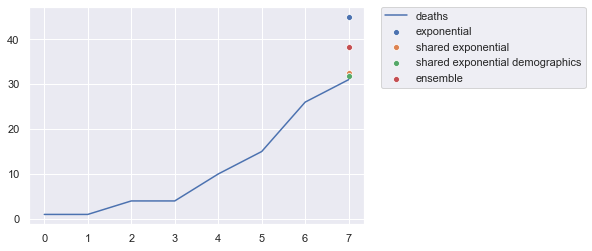

PopulationDensityperSqMile2010: 1385.8
MedicareEnrollment,AgedTot2017: 201307.0
PopulationEstimate2018: 1259201.0
#ICU_beds: 409
MedianAge2010: 40.2
Smokers_Percentage: 12.308266081
DiabetesPercentage: 7.7
HeartDiseaseMortality: 181.4
#Hospitals: 12


Bergen in NJ


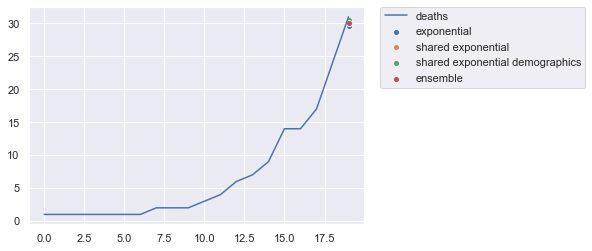

PopulationDensityperSqMile2010: 3884.5
MedicareEnrollment,AgedTot2017: 151926.0
PopulationEstimate2018: 936692.0
#ICU_beds: 147
MedianAge2010: 41.1
Smokers_Percentage: 11.410986988
DiabetesPercentage: 6.8
HeartDiseaseMortality: 140.1
#Hospitals: 6


Cook in IL


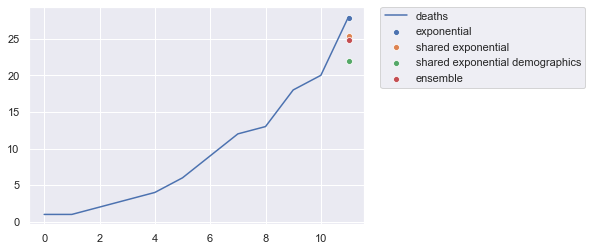

PopulationDensityperSqMile2010: 5495.1
MedicareEnrollment,AgedTot2017: 686929.0
PopulationEstimate2018: 5180493.0
#ICU_beds: 1606
MedianAge2010: 35.3
Smokers_Percentage: 13.776183162
DiabetesPercentage: 9
HeartDiseaseMortality: 175.1
#Hospitals: 46


Jefferson in LA


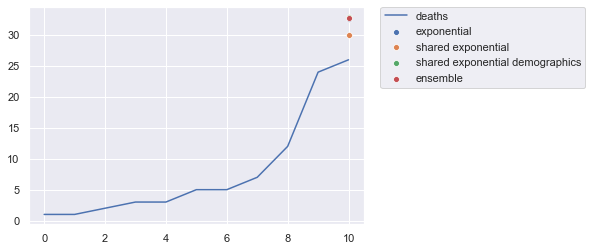

PopulationDensityperSqMile2010: 1463.1
MedicareEnrollment,AgedTot2017: 70146.0
PopulationEstimate2018: 434051.0
#ICU_beds: 215
MedianAge2010: 38.4
Smokers_Percentage: 18.743669593
DiabetesPercentage: 12.7
HeartDiseaseMortality: 178.7
#Hospitals: 5


Santa Clara in CA


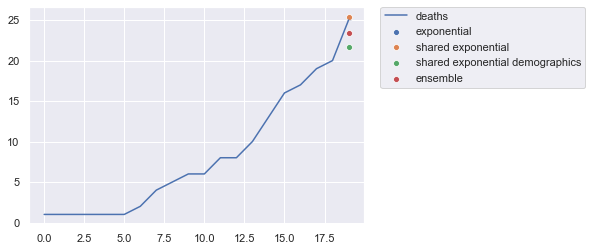

PopulationDensityperSqMile2010: 1381.0
MedicareEnrollment,AgedTot2017: 237461.0
PopulationEstimate2018: 1937570.0
#ICU_beds: 313
MedianAge2010: 36.2
Smokers_Percentage: 8.2690140125
DiabetesPercentage: 7.3
HeartDiseaseMortality: 104.2
#Hospitals: 9


Snohomish in WA


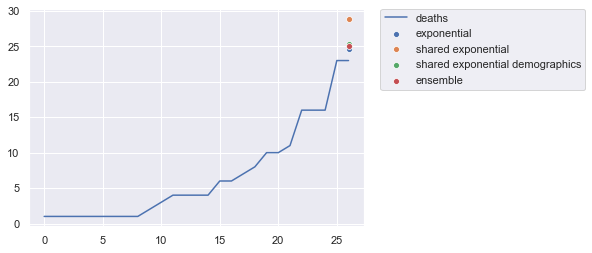

PopulationDensityperSqMile2010: 341.8
MedicareEnrollment,AgedTot2017: 102993.0
PopulationEstimate2018: 814901.0
#ICU_beds: 72
MedianAge2010: 37.1
Smokers_Percentage: 12.962308599
DiabetesPercentage: 7.7
HeartDiseaseMortality: 131.9
#Hospitals: 4


Fairfield in CT


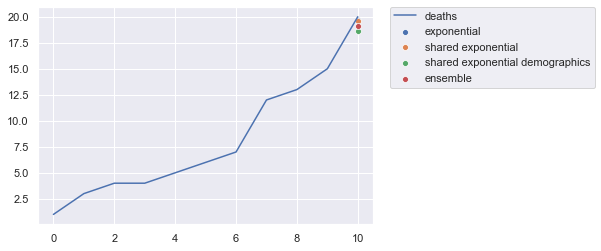

PopulationDensityperSqMile2010: 1467.2
MedicareEnrollment,AgedTot2017: 136996.0
PopulationEstimate2018: 943823.0
#ICU_beds: 173
MedianAge2010: 39.5
Smokers_Percentage: 10.157896011
DiabetesPercentage: 6.4
HeartDiseaseMortality: 137.1
#Hospitals: 6


Middlesex in NJ


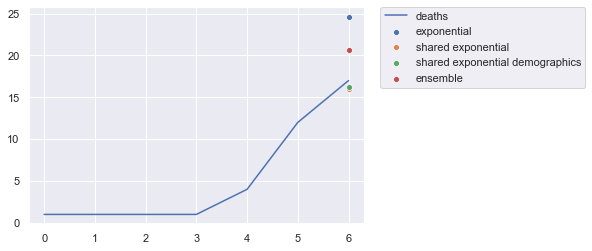

PopulationDensityperSqMile2010: 2621.6
MedicareEnrollment,AgedTot2017: 114772.0
PopulationEstimate2018: 829685.0
#ICU_beds: 185
MedianAge2010: 37.2
Smokers_Percentage: 10.970467888
DiabetesPercentage: 9.7
HeartDiseaseMortality: 154.3
#Hospitals: 5


Dougherty in GA


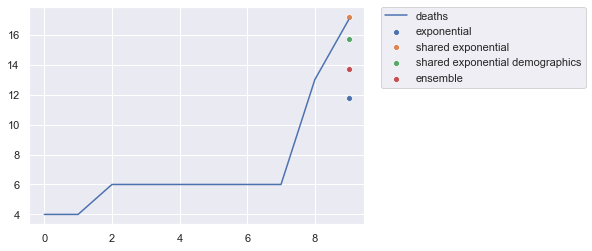

PopulationDensityperSqMile2010: 287.7
MedicareEnrollment,AgedTot2017: 13419.0
PopulationEstimate2018: 91243.0
#ICU_beds: 50
MedianAge2010: 33.2
Smokers_Percentage: 21.607553194
DiabetesPercentage: 13.8
HeartDiseaseMortality: 178.8
#Hospitals: 1


Macomb in MI


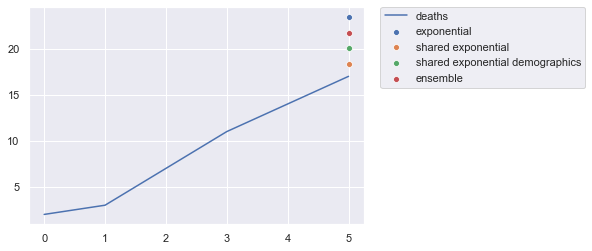

PopulationDensityperSqMile2010: 1754.9
MedicareEnrollment,AgedTot2017: 141612.0
PopulationEstimate2018: 874759.0
#ICU_beds: 122
MedianAge2010: 39.9
Smokers_Percentage: 18.558096157
DiabetesPercentage: 9.5
HeartDiseaseMortality: 196.6
#Hospitals: 4


Essex in NJ


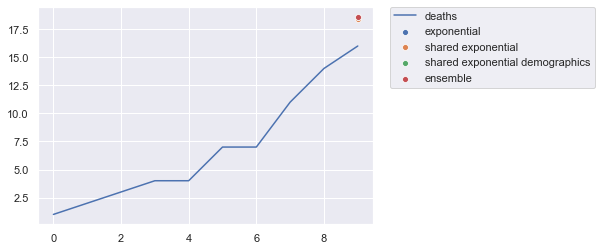

PopulationDensityperSqMile2010: 6211.5
MedicareEnrollment,AgedTot2017: 98231.0
PopulationEstimate2018: 799767.0
#ICU_beds: 267
MedianAge2010: 36.4
Smokers_Percentage: 14.235389268
DiabetesPercentage: 9.9
HeartDiseaseMortality: 169.8
#Hospitals: 7


Clark in NV


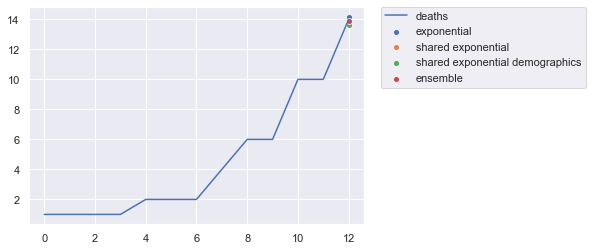

PopulationDensityperSqMile2010: 247.3
MedicareEnrollment,AgedTot2017: 286927.0
PopulationEstimate2018: 2231647.0
#ICU_beds: 535
MedianAge2010: 35.5
Smokers_Percentage: 16.979704666
DiabetesPercentage: 10
HeartDiseaseMortality: 204.3
#Hospitals: 19


Fulton in GA


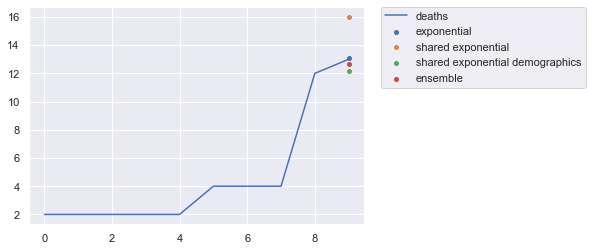

PopulationDensityperSqMile2010: 1748.1
MedicareEnrollment,AgedTot2017: 110106.0
PopulationEstimate2018: 1050114.0
#ICU_beds: 538
MedianAge2010: 34.2
Smokers_Percentage: 14.925509463
DiabetesPercentage: 8.3
HeartDiseaseMortality: 157.6
#Hospitals: 7


Morris in NJ


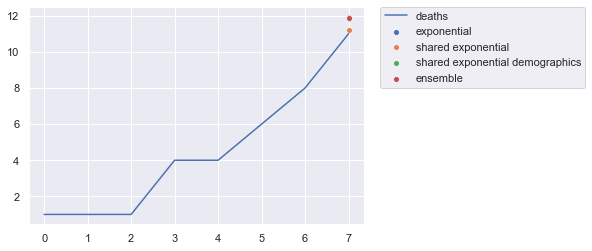

PopulationDensityperSqMile2010: 1069.8
MedicareEnrollment,AgedTot2017: 79845.0
PopulationEstimate2018: 494228.0
#ICU_beds: 91
MedianAge2010: 41.3
Smokers_Percentage: 12.111935176
DiabetesPercentage: 6.3
HeartDiseaseMortality: 143.5
#Hospitals: 3


Broward in FL


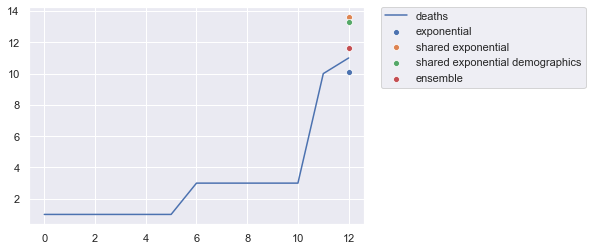

PopulationDensityperSqMile2010: 1444.9
MedicareEnrollment,AgedTot2017: 272414.0
PopulationEstimate2018: 1951260.0
#ICU_beds: 587
MedianAge2010: 39.7
Smokers_Percentage: 14.593792551
DiabetesPercentage: 8.1
HeartDiseaseMortality: 146.9
#Hospitals: 14




In [118]:
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    row = df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        print(row['CountyName']+' in '+row['StateNameAbbreviation'])
        plot_prediction(row)
        for v in very_important_vars:
            print(v+ ': '+str(row[v]))
        print('\n')